In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import pickle
import helper_functions_06b as hf

In [2]:
DATE = ['20230302']#, '20230303']
SESSION = ['SM_Lek1', 'SE_Lek1']
DRONE = ['P1D1', 'P1D2', 'P2D3', 'P2D4', 'P3D5', 'P3D6']

tracking_directory = '/Volumes/EAS_shared/blackbuck/working/processed/TerritoryDetection2023'

In [3]:
# Thresholds for translation, rotation, and scale
thresholds = {
    'T_translation': 30,  # e.g., 30 pixels
    'T_rotation': 20,     # e.g., 20 degrees
    'T_scale': 0.1         # e.g., 10% change
}

In [4]:
for date in DATE:
    for session in SESSION:
        for drone in DRONE:
            internal_path = tracking_directory + '/' + date + '/' + session + '/' + drone
            files = glob.glob(internal_path + '/' + date + '_' + session + '_' + drone + '*_tracked.csv')
            
            for file in files:
                df = pd.read_csv(file)
                
                df['x'] = df['bb_left'] + df['bb_width']/2
                df['y'] = df['bb_top'] + df['bb_height']/2
                df['idx'] = df['track_id']

                df = df.loc[:,['frame', 'x', 'y', 'idx']]
                
                # Step 1: Identify anchor frames
                anchor_frames = hf.identify_anchor_frames(df, thresholds)

                # Step 2: Find the best anchor for each frame
                df = hf.find_best_anchor_for_each_frame(df, anchor_frames, thresholds)

                # Step 3: Apply homography using the best anchor for each frame
                df, homography_matrices, rms_errors = hf.apply_homography_to_best_anchor(df)

                df.to_csv(file[:-17] + '_Anchored.csv', index=False, mode='w')
                with open(file[:-17] + '_homographies.pkl', 'wb') as f:
                    pickle.dump(homography_matrices, f)

Initial identification of anchors takes  70.46273803710938
Finding the best anchors takes  71.41067600250244
Applying homography to the best anchors takes  195.98904085159302
Initial identification of anchors takes  37.13550305366516
Finding the best anchors takes  37.93884325027466
Applying homography to the best anchors takes  118.51974105834961


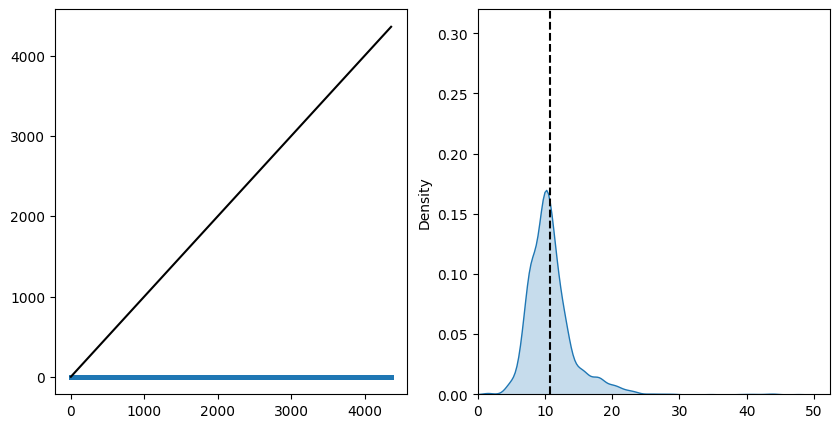

In [19]:
mean_rms_error = sum(rms_errors.values()) / len(rms_errors)


fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.scatter(df['frame'], df['idx'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)

ax2.scatter(df['frame'], df['best_anchor_frame'], s=5)
ax2.plot(np.linspace(0,df['frame'].max()), np.linspace(0,df['frame'].max()), c='black')

sns.kdeplot(rms_errors, fill=True, ax=ax3)
ax3.vlines(mean_rms_error,0,0.32,color='black',linestyles='dashed')
ax3.set_xlim(0,)
ax3.set_ylim(0,0.32)

plt.show()